<a href="https://colab.research.google.com/github/julienVLNT/python-sandbox/blob/main/EDP/ondes_FD_FE_SE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.13


**Julien VALENTIN**, **mars 2022** d'après le MOOC *Computers, Waves, Simulations: A Practical Introduction to Numerical Methods using Python* de l'Université Louis-et-Maximilien de Munich (LMU)

> https://www.coursera.org/learn/computers-waves-simulations?

In [2]:
from matplotlib import gridspec
from matplotlib import pyplot
from matplotlib import rc
rc('animation', html='html5')

import numpy

import warnings
warnings.filterwarnings("ignore")

# Ondes acoustiques en 1.D par différences finies

### Description de l'algorithme

On s'intéresse à l'équation des ondes 

$$ \partial^2_t p(t;x) \ = \ c(x)^2 \partial_x^2 p(t;x) + s(t;x) $$

où $p$ représente la pression dans un milieu, $c$ la vitesse du son et $s$ un terme source. Cette équation est celle des ondes acoustiques. Dans cette partie, on attaque le problème par méthode des différences finies classique.

Formellement, l'écriture des développements de Taylor de $p$ en temps puis en espace, écrits en $x_i$, $x_i-dx$, $x_i+dx$ ou en $t_n$, $t_n-dt$ et $t_n+dt$ et une troncature permettent d'obtenir

$$ \partial^2_t p(t; x) \ \approx \ \frac{p(t+dt; x) - 2 p(t; x) + p(t-dt; x)}{dt^2} $$

On obtient la semi-discrétisation explicite

$$ p_{i}^{n+1} \ = \ c_i^2 \mathrm{d}t^2 \left[ \partial_x^2 p \right]
+ 2p_{i}^n - p_{i}^{n-1} + \mathrm{d}t^2 s_{i}^n $$

avec le laplacien en espace approché par :

$$ \partial_x^2 p \ = \ \frac{p_{i+1}^{n} - 2 p_{i}^n + p_{i-1}^{n}}{\mathrm{d}x^2} $$



#### Setup

In [3]:
nx   = 10000          # nombre de points de discrétisation en espace
xmax = 10000          # longueur du domaine physique (m)
dx   = xmax/(nx-1)    # pas d'espace dans la direction x
c0   = 334.           # vitesse de l'onde dans le milieu (m/s)
isrc = int(nx/2)      # indice du point de localisation de la source s
ir   = isrc + 100     # indice du point où se situe le micro
nt   = 1001           # nombre d'extrapolations en temps
dt   = 0.0010         # pas de temps

# Fonction second membre
f0   = 25.        # fréquence dominante de la source (Hz)
t0   = 4. / f0    # time shift

# Fonction source temporelle (gaussienne)
src  = numpy.zeros(nt + 1)
time = numpy.linspace(0 * dt, nt * dt, nt)
src  = -8. * (time - t0) * f0 * (numpy.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2))    # dérivée première de la fonction gaussienne

# Initialisation
p    = numpy.zeros(nx)    # p au temps tn
pold = numpy.zeros(nx)    # p au temps tn-1 (past)
pnew = numpy.zeros(nx)    # p au temps n+1 (present)
d2px = numpy.zeros(nx)    # dérivée spatiale seconde de p

# Initialisation du modèle de matériau (homogène)
c    = numpy.zeros(nx)
c    = c + c0    # vitesse du son dans le matériau

# Initialisation des coordonnées physiques
x    = numpy.arange(nx)
x    = x * dx

#### Visualisation de la source et de son spectre

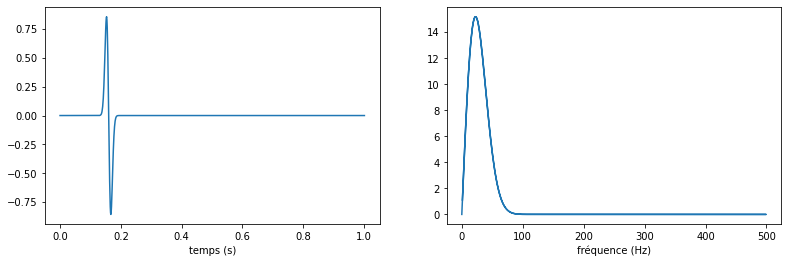

In [4]:
figure, ax, = pyplot.subplots(nrows=1, ncols=2)
figure.set_figwidth(2.2 * figure.get_figwidth())

ax[0].plot(time, src)
ax[0].set_xlabel("temps (s)")

spec = numpy.fft.fft(src)
freq = numpy.fft.fftfreq(spec.size, d=dt)
ax[1].plot(numpy.abs(freq), numpy.abs(spec))
ax[1].set_xlabel("fréquence (Hz)")

pyplot.show()

#### Extrapolation en temps

In [5]:
for it in range(nt):    # itération temporelle

    for i in range(1, nx - 1):    # calcul de la dérivée spatiale seconde à l'intérieur
        d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2

    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px    # extrapolation temporelle

    pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2    # prise en compte du terme source
                
    pold, p = p, pnew

#### Visualisation de la situation finale

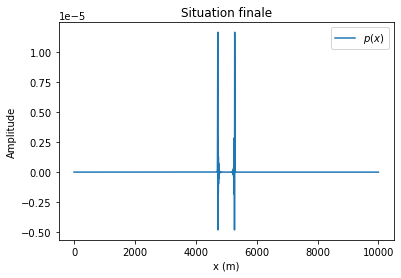

In [6]:
pyplot.plot(x, p, label="$p(x)$")
pyplot.legend()
pyplot.title("Situation finale")
pyplot.xlabel("x (m)")
pyplot.ylabel("Amplitude")
pyplot.show()

### Comparaison avec une solution analytique

In [7]:
# Initialisation de la solution analytique
G = time * 0.
for it in range(nt):    # calcul de la fonction de Green du problème (distribution de Heaviside)
    if (time[it] - numpy.abs(x[ir] - x[isrc]) / c0) >= 0:
        G[it] = 1. / (2 * c0)
Gc   = numpy.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max()

#### Séismogramme vierge

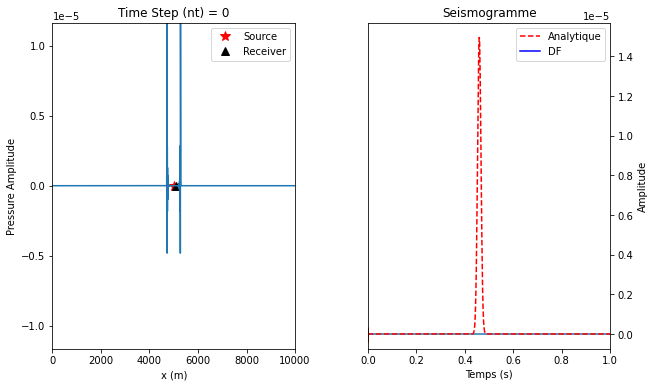

In [8]:
seis = numpy.zeros(nt) 

pyplot.ion()
fig = pyplot.figure(figsize=(10, 6))
gs  = gridspec.GridSpec(1, 2, width_ratios=[1,1], hspace=0.3, wspace=0.3)

ax1  = pyplot.subplot(gs[0])
leg1,= ax1.plot(isrc, 0, 'r*', markersize=11)
leg2,= ax1.plot(ir, 0, 'k^', markersize=8)
up31,= ax1.plot(p)
ax1.set_xlim(0, xmax)
ax1.set_ylim(-numpy.max(p), numpy.max(p))
ax1.set_title('Time Step (nt) = 0')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('Pressure Amplitude')
ax1.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

ax2  = pyplot.subplot(gs[1])
leg3,= ax2.plot(0,0,'r--',markersize=1)
leg4,= ax2.plot(0,0,'b-',markersize=1)
up41,= ax2.plot(time, seis)
up42,= ax2.plot([0], [0], 'r|', markersize=15)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlim(time[0], time[-1])
ax2.set_title('Seismogramme')
ax2.set_xlabel('Temps (s)')
ax2.set_ylabel('Amplitude')
ax2.legend((leg3, leg4), ('Analytique', 'DF'), loc='upper right', fontsize=10, numpoints=1)

pyplot.plot(time,Gc,'r--')
pyplot.show()

#### Extrapolation en temps

In [9]:
# Initialisation
p    = numpy.zeros(nx)    # p au temps tn
pold = numpy.zeros(nx)    # p au temps tn-1 (past)
pnew = numpy.zeros(nx)    # p au temps n+1 (present)
d2px = numpy.zeros(nx)    # dérivée spatiale seconde de p

eps = c0 * dt / dx    # critère de stabilité du schéma

######################################################
# EXTRAPOLATION EN TEMPS
# ----------------------
for it in range(nt):    # itération en temps
    for i in range(1, nx - 1):    # itération en espace
        d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2    # calcul du laplacien à l'intérieur

    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px         # extrapolation
    pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2    # prise en compte de la source

    pold, p = p, pnew    # mapping

    seis[it] = p[ir]

    idisp = 5 # display frequency
    if (it % idisp) == 0:
        ax1.set_title('Time Step (nt) = %d' % it)
        ax1.set_ylim(numpy.min(p), 1.1*numpy.max(p))
        # plot around propagating wave
        window=100; xshift=25
        ax1.set_xlim(isrc*dx+c0*it*dt-window*dx-xshift, isrc*dx+c0*it*dt+window*dx-xshift)
        up31.set_ydata(p)
        up41.set_ydata(seis)
        up42.set_data(time[it], seis[it])
        pyplot.gcf().canvas.draw()
######################################################

<Figure size 432x288 with 0 Axes>

# Ondes acoustiques 2.D par méthode pseudo-spectrale et comparaison avec différences finies

## Description de l'algorithme

Dans le plan $(O, x, z)$, on pose l'équation d'ondes 

$$ \partial_t^2 p = c^2 (\partial_{x}^{2}p + \partial_{z}^{2}p) + s $$

où $p$ est le champ de pression, $c$ la vitesse du son dans le milieu et $s$ une source. Dans ce chapitre, on attaque le problème par différences finies appliquée au spectre du champ $p$ pour estimer ses dérivées dans l'espace physique

$$ \partial_{x}^{2}p + \partial_{z}^{2}p = \mathscr{F}^{-1}[-k_{x}^{2}\mathscr{F}[p]] + \mathscr{F}^{-1}[-k_{z}^{2}\mathscr{F}[p]] $$

et $\mathscr{F}$ représente la transformation de Fourier. On utilise le stencil à trois points pour l'extrapolation en temps, ce qui donne le schéma explicite

$$ \frac{p_{j,k}^{n+1} - 2p_{j,k}^{n} + p_{j,k}^{n-1}}{dt^2}= c_{j,k}^{2} (\partial_{x}^{2}p + \partial_{z}^{2}p)_{j,k} + s_{j,k}^{n} $$

On suppose que la source $s$ est une onde de type Ricker, c.f chapitre sur les éléments spectraux pour plus de détails.

#### Dérivation spectrale

In [10]:
def fourier_derivative_2nd(f: numpy.ndarray, dx: float):
    "Calcul de la dérivée seconde spatiale du champ f."
    nx = numpy.size(f)
    
    # Construction du multiplicateur k à nombre de Nyquist près
    kmax = numpy.pi / dx
    dk = kmax / (nx / 2)
    k = numpy.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Dérivation d'ordre 2
    ff = numpy.fft.fft(f)                      # spectre du champ f
    ff = (1j*k)**2 * ff                        # multiplication par (ik)^2
    df_num = numpy.real(numpy.fft.ifft(ff))    # application de la transformation de Fourier inverse

    return df_num

#### Setup

In [11]:
nt    = 600     # nombre de points de la discrétisation en temps
nx    = 256     # nombre de points de la discrétisation selon (Ox)
nz    = nx      # nombre de points de la discrétisation selon (Oz)
c     = 343.    # vitesse du son dans le milieu [m/s]
eps   = .2      # critère de stabilité
isx   = int(nx/2)   # indice de la localisation de la source selon (Ox)
isz   = int(nz/2)   # indice de la localisation de la source selon (Oz)
f0    = 200.    # fréquence (div par 5)
xmax  = 200     # longueur du domaine spatial

# initialisation des champs de pression
# nécessaires pour les calculs
ap = numpy.zeros((nx, nz), dtype=float)
apnew = numpy.zeros((nx, nz), dtype=float)
apold = numpy.zeros((nx, nz), dtype=float)
ad2px = numpy.zeros((nx, nz), dtype=float)
ad2pz = numpy.zeros((nx, nz), dtype=float) 
 
sp = numpy.zeros((nx, nz), dtype= float)
spnew = numpy.zeros((nx, nz), dtype=float)
spold = numpy.zeros((nx, nz), dtype=float)
sd2px = numpy.zeros((nx, nz), dtype=float)
sd2pz = numpy.zeros((nx, nz), dtype=float); 

sp_sec = -numpy.abs(sp[1:int(nx/2), 1:int(nz/2)])
ap_sec = -numpy.abs(ap[int(nx/2):nx, 1:int(nz/2)].T)

dx = xmax/(nx-1)               # pas d'espace de la discrétisation spatiale [m] (et dz = dx)
x  = numpy.arange(0, nx)*dx    # construction des coordonnées horizontales [m]
z  = numpy.arange(0, nx)*dx    # construction des coordonnées verticales [m]
dt = eps*dx/c                  # calculate tim step from stability criterion

#### Source

In [12]:
def ricker(dt, pt):
    """
    Calcul d'une onde de Ricker.
    
    PARAMETRES
    ----------
    dt : float,
         pas de temps
    pt : float,
         période de l'onde de Ricker
    
    RETOUR
    ------
    c : numpy.ndarray,
        valeur de l'onde psi(t)
    """
    nt = int(2 * pt / dt)
    c = numpy.zeros(nt)
    t0 = pt / dt
    a_ricker = 4 / pt

    for it in range(0, nt):
        t = ((it + 1) - t0) * dt
        c[it] = -2 * a_ricker * t * numpy.exp(-(a_ricker * t) ** 2)

    return c

# Source temporelle
t   = numpy.arange(1, nt+1)*dt    # vecteur des dates de la simulation
T0  = 1./f0                       # période dominante
tmp = ricker(dt, T0)              # valeurs temporelles de l'onde de Ricker
tmp = numpy.diff(tmp)             # dérivation temporelle d'ordre 1
src = numpy.zeros(nt)             
src[0:numpy.size(tmp)] = tmp      # source
lam = c*T0

# Source spatiale
sg = numpy.zeros((nx, nz))
sigma = 1.5*dx
x0 = x[isx-1] 
z0 = z[isz-1] 
for i in range(nx):    # itération spatiale (Ox)
    for j in range(nz):    # itération spatiale (Oz)
        sg[i,j] = numpy.exp(-1/sigma**2 * ((x[i]-x0)**2 +(z[j]-z0)**2))
        
sg = sg/numpy.amax(sg)

#### Extrapolation en temps

In [13]:
for it in range(nt):

    # ----------------------------------------
    # Méthode pseudo-spectrale
    # ----------------------------------------
    # dérivée spatiale seconde
    for j in numpy.arange(nz):           
        sd2px[:,j] = fourier_derivative_2nd(sp[:,j].T, dx) 
    for i in numpy.arange(nx):           
        sd2pz[i,:] = fourier_derivative_2nd(sp[i,:], dx)
        
    # extrapolation temporelle
    spnew = 2*sp - spold + c**2 * dt**2 * (sd2px + sd2pz)    
    spnew = spnew + sg*src[it]*dt**2    # prise en compte des sources   
    spold, sp = sp, spnew

    # ----------------------------------------
    # Différences Finies stencil à cinq points
    # ----------------------------------------
    # dérivée spatiale seconde
    for i in range(2, nz-2):
        ad2px[i,:] = (-1./12*ap[i+2,:] + 4./3*ap[i+1,:] - 5./2*ap[i,:] \
                      + 4./3*ap[i-1,:] - 1./12*ap[i-2,:])/dx**2
    for i in range(2, nx-2):
        ad2pz[:,i] = (-1./12*ap[:,i+2] + 4./3*ap[:,i+1] - 5./2*ap[:,i] \
                      + 4./3*ap[:,i-1] - 1./12*ap[:,i-2])/dx**2
        
    apnew = 2*ap - apold + dt**2 * c**2 * (ad2px + ad2pz)    # extrapolation en temps    
    apnew = apnew + sg*src[it]*dt**2    # prise en compte des sources
    apold, ap = ap, apnew

#### Visualisation

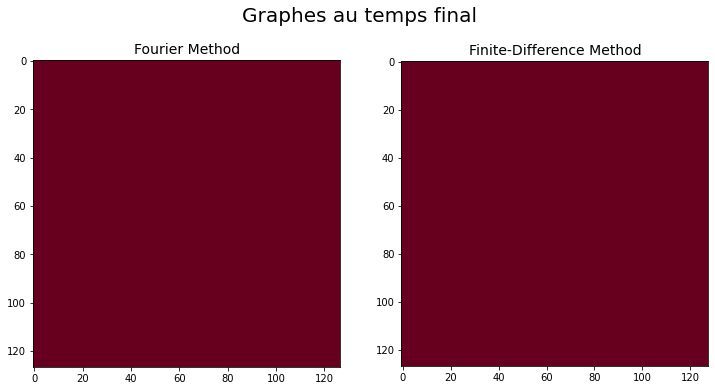

In [14]:
fig = pyplot.figure(figsize=(12.1,6))
fig.suptitle("Graphes au temps final", size=20)

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

line1 = ax1.imshow(sp_sec, interpolation="bicubic", cmap=pyplot.cm.RdBu)
line2 = ax2.imshow(ap_sec, interpolation="bicubic", cmap=pyplot.cm.RdBu)

ax1.set_title('Fourier Method', size=14)
ax2.set_title('Finite-Difference Method', size=14)

pyplot.show()

Nous aurions dû obtenir, à l'issue d'une animation

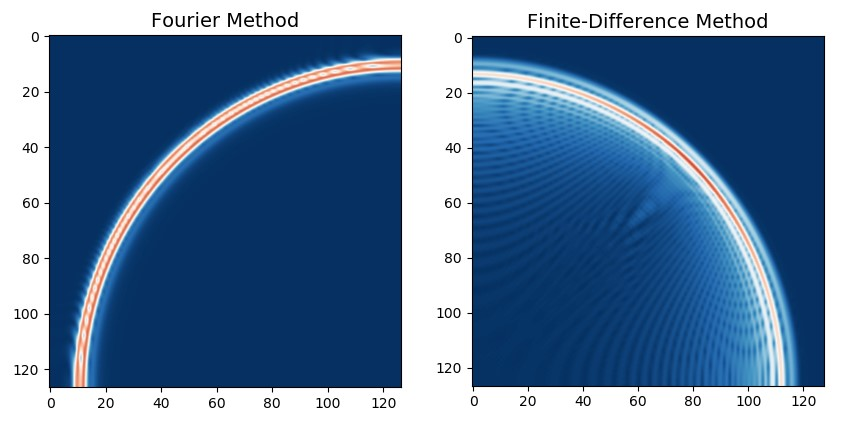

> https://github.com/heinerigel/coursera/blob/master/Notebooks4Coursera/W5/W5_ps_fourier_acoustic_2d.ipynb

et constater que la méhode pseudo-spectrale est bien plus précise, elle diminue l'anisotropie.

# Elasticité dynamique 1.D par éléments finis

## Description de l'algorithme

Soit à résoudre dans une cavité rectangulaire

$$ \rho(x) \partial_t^2 u(t; x) = \partial_x (\mu(x) \partial_x u(t; x)) + f(t; x) $$ 

1) **Recherche de la formulation variationnelle** par intégration sur le domaine $\Omega$ après multiplication par une fonction test $\varphi_{i}$.

2) **Application des conditions de Neumann** aux bords : *stress-free conditions*

3) **Approximation du champ $u$**, déplacement fonction du temps et de l'espace, par interpolation à l'aide de poids $u_i(t)$ dans une base de fonctions de l'espace $\varphi_i(x)$

$$ u(x,t) \ \approx \ \overline{u}(x,t) \ = \ \sum_{i=1}^{n} u_i(t) \ \varphi_i(x) $$

4) **Construction du système linéaire**

$$ \mathbf{M}^T\partial_t^2 \mathbf{u} + \mathbf{K}^T\mathbf{u} = \mathbf{f} $$

5) **Discrétisation temporelle par différences finies**

$$ \mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt) $$

6) **Choix des interpolants**

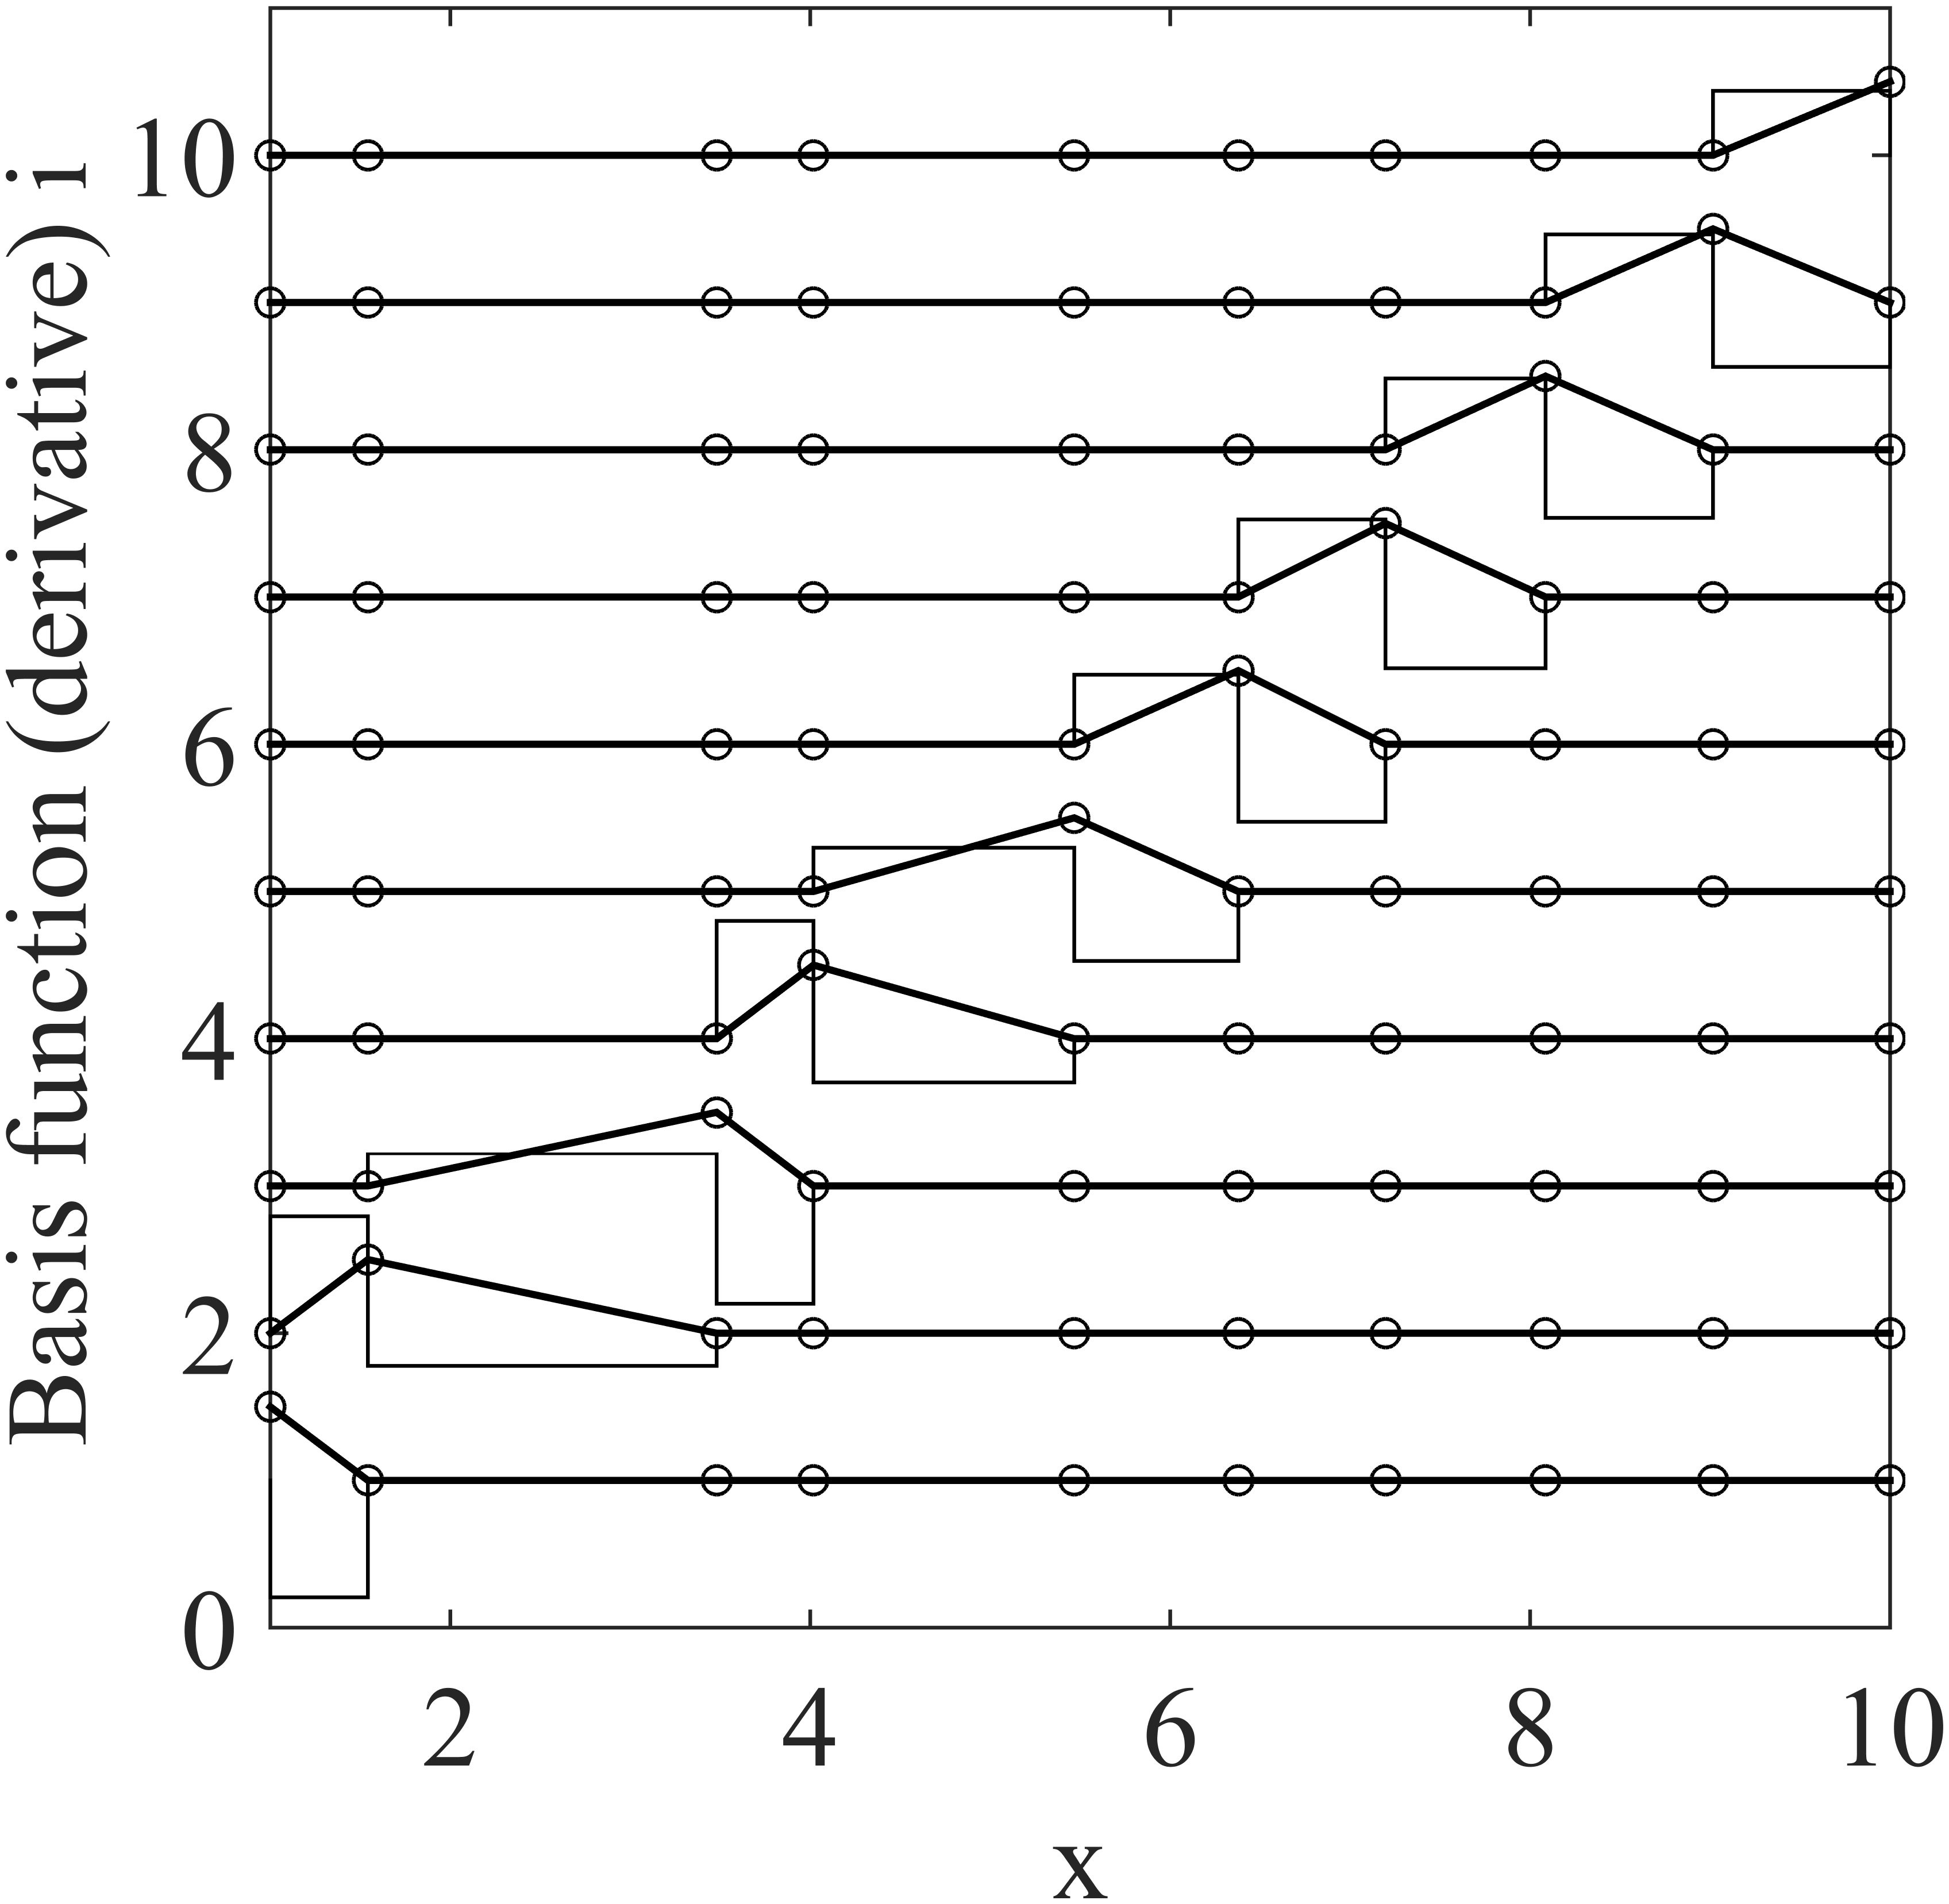

> 

\begin{equation}
 \varphi_{i}(\xi) =
  \begin{cases}
    \frac{\xi}{h_{i-1}} + 1  & \quad \text{if} \quad -h_{i-1} \le \xi \le 0\\
    1 + \frac{\xi}{h_{i}}    & \quad \text{if} \quad 0 \le \xi \le h_{i}\\
    0  & \quad elsewhere\\
  \end{cases}
\end{equation}

dont les dérivées sont

\begin{equation}
 \partial_{\xi}\varphi_{i}(\xi) =
  \begin{cases}
    \frac{1}{h_{i-1}}  & \quad \text{if} \quad -h_{i-1} \le \xi \le 0\\
   -\frac{1}{h_{i}}    & \quad \text{if} \quad 0 \le \xi \le h_{i}\\
    0  & \quad elsewhere\\
  \end{cases}
\end{equation}

#### Setup

In [15]:
nx    = 1000    # nombre de points de la discrétisation spatiale
xmax  = 10000.  # longueur du domaine [m]
vs    = 3000    # célérité dans le matériau [m/s] 
ro0   = 2500    # densité du matériau [kg/m^3]
nt    = 2000    # nombre de dates
isx   = 500     # indice du point de la source [m] 
eps   = 0.5     # critère de stabilité

dx = xmax/(nx-1)              # pas d'espace maximal
x  = numpy.arange(0, nx)*dx   # coordonnées spatiales
x  = numpy.transpose(x)       # vecteur colonne

h = numpy.diff(x)    # longueur d'un élément [m]

ro = x*0 + ro0         # densité du matériau (homogène)
mu = x*0 + ro*vs**2    # module de cisaillement

dt = 0.5*eps*dx/numpy.max(numpy.sqrt(mu/ro))    # pas de temps de la simulation
t  = numpy.arange(1, nt+1)*dt                   # vecteur des dates de la simulations

# Initialisation des champs
u    = numpy.zeros(nx)
uold = numpy.zeros(nx)
unew = numpy.zeros(nx)

p    = numpy.zeros(nx)
pold = numpy.zeros(nx)
pnew = numpy.zeros(nx)

# Initialisation de la source
pt  = 20*dt     # Gaussian width
t0  = 3*pt      # Time shift
src = -2/pt**2 * (t-t0) * numpy.exp(-1/pt**2 * (t-t0)**2)

f = numpy.zeros(nx);
f[isx:isx+1] = f[isx:isx+1] + 1.    # vecteur source

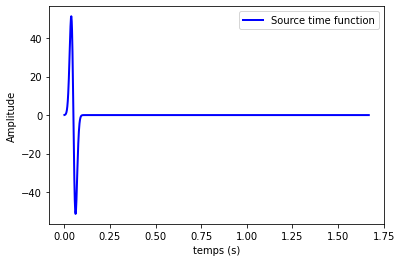

In [16]:
pyplot.plot(t, src, color='b', lw=2, label='Source time function')
pyplot.legend()
pyplot.xlabel('temps (s)')
pyplot.ylabel('Amplitude')
pyplot.show()

#### Matrice de masse

$$ M_{ij} = \int_{D} \rho \varphi_i \varphi_j dx = \int_{D_{\xi}} \rho \varphi_i \varphi_j d\xi $$

et, *after some algebra* 

\begin{equation}
M_{ij} = \frac{\rho h}{6}
 \begin{pmatrix}
   \ddots  &    &    &    & 0\\
   1 & 4 &  1 &    &  \\
     & 1 &  4 &  1 &  \\
     &   &  1 &  4 & 1\\
   0 &   &    &    &  \ddots
 \end{pmatrix} 
\end{equation}

In [17]:
M = numpy.zeros((nx,nx))

# Affectation à l'intérieur
for i in range(1, nx-1):    # itération sur les lignes
    for j in range (1, nx-1):    # itération sur les colonnes
        if j==i:    # diagonale
            M[i,j] = (ro[i-1]*h[i-1] + ro[i]*h[i])/3
        elif j==i+1:    # sur-diagonale
            M[i,j] = ro[i]*h[i]/6
        elif j==i-1:    # sous-diagonale
            M[i,j] = ro[i-1]*h[i-1]/6
        else:           # --> penser à la représentation creuse (scipy.sparse)
            M[i,j] = 0

# Affectation des coins
M[0,0] = ro[0]*h[0]/3
M[nx-1,nx-1] = ro[nx-1]*h[nx-2]/3

# Inversion
Minv = numpy.linalg.inv(M)

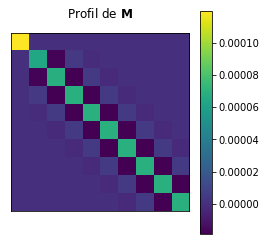

In [18]:
pyplot.matshow(Minv[:10, :10])
pyplot.colorbar()
pyplot.grid(False)
pyplot.title("Profil de $\mathbf{M}$")
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

#### Matrice de raideur

\begin{equation}
K_{ij} = \int_{D} \mu \partial_x\varphi_i \partial_x\varphi_j dx = \int_{D_{\xi}} \mu \partial_\xi\varphi_i \partial_\xi\varphi_j d\xi
\end{equation} 

et, *after some algebra* 

\begin{equation}
K_{ij} = \frac{\mu}{h}
 \begin{pmatrix}
   \ddots  &    &    &    & 0\\
  -1 & 2 & -1 &    &  \\
     &-1 &  2 & -1 &  \\
     &   & -1 &  2 & -1\\
   0 &   &    &    &  \ddots
 \end{pmatrix} 
\end{equation}

In [19]:
K = numpy.zeros((nx,nx))

# Remplissage à l'intérieur
for i in range(1, nx-1):    # itération sur les lignes
    for j in range(1, nx-1):    # itération sur les colonnes
        if i==j:    # diagonale
            K[i,j] = mu[i-1]/h[i-1] + mu[i]/h[i]
        elif i==j+1:    # sous-diagonale
            K[i,j] = -mu[i-1]/h[i-1]
        elif i+1==j:    # sur-diagonale
            K[i,j] = -mu[i]/h[i]
        else:    # penser à la représentation creuse
            K[i,j] = 0

# Remplissage des coins
K[0,0] = mu[0]/h[0]
K[nx-1,nx-1] = mu[nx-1]/h[nx-2]

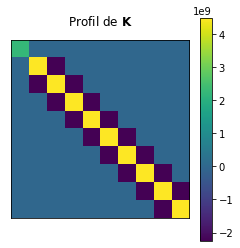

In [20]:
pyplot.matshow(K[:10, :10])
pyplot.colorbar()
pyplot.grid(False)
pyplot.title("Profil de $\mathbf{K}$")
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

#### Masse et raideur par différences finies

In [21]:
Mfd = numpy.zeros((nx,nx))
D   = numpy.zeros((nx,nx))
dx  = h[1]

for i in range(nx):
    Mfd[i,i] = 1./ro[i]
    if i>0:
        if i<nx-1:
            D[i+1,i] =1
            D[i-1,i] =1
            D[i,i] = -2
            
D = ro0 * vs**2 * D/dx**2

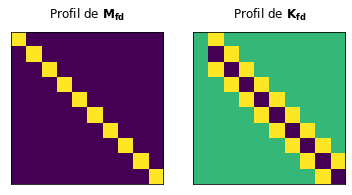

In [22]:
fig, ax, = pyplot.subplots(nrows=1, ncols=2)
ax[0].matshow(Mfd[:10,:10])
ax[0].grid(False)
ax[0].set_title("Profil de $\mathbf{M_{fd}}$")
ax[0].set_xticks([])
ax[0].set_yticks([])


ax[1].matshow(D[:10,:10])
ax[1].grid(False)
ax[1].set_title("Profil de $\mathbf{K_{fd}}$")
ax[1].set_xticks([])
ax[1].set_yticks([])

pyplot.show()

#### Extrapolation en temps

$$ \mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt) $$

In [23]:
for it in range(nt):

    # Méthode éléments finis
    unew = (dt**2) * Minv @ (f*src[it]  -  K @ u) + 2*u - uold                         
    uold, u = u, unew
    
    # Méthode différences finies
    pnew = (dt**2) * Mfd @ ( f/dx*src[it]+ D @ p) + 2*p - pold
    pold, p = p, pnew

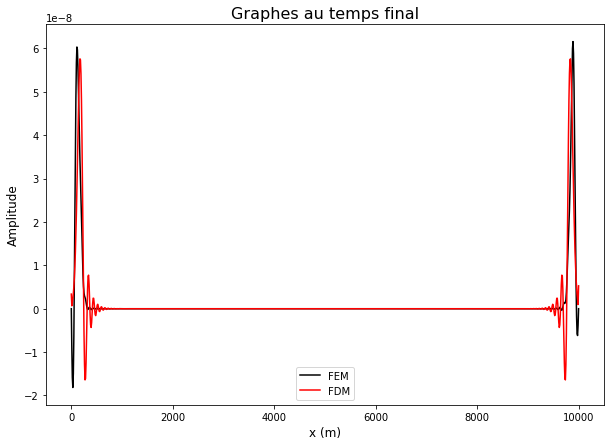

In [24]:
pyplot.figure(figsize=(10,7))

pyplot.plot(x, u, 'k', lw=1.5, label='FEM')
pyplot.plot(x, p, 'r', lw=1.5, label='FDM')

pyplot.legend()
pyplot.title('Graphes au temps final', fontsize=16)
pyplot.ylabel('Amplitude', fontsize=12)
pyplot.xlabel('x (m)', fontsize=12)
pyplot.show()

# Interpolation de Lagrange aux points G.L.L et intégration

On commence par récupérer le script `gll.py` qui contient la définition des points de Gauss-Lobatto-Legendre. Ce script est issu de 

> https://github.com/heinerigel/coursera/blob/master/Notebooks4Coursera/W9/gll.py

basé sur la thèse de Bernhard Schuberth

> https://www.geophysik.uni-muenchen.de/~bernhard/downloads/Diploma_Thesis_Bernhard_Schuberth.pdf

In [25]:
def gll(N):
    """
    Returns GLL (Gauss Lobato Legendre module with collocation points and
    weights)
    """
    # Initialization of integration weights and collocation points
    # [xi, weights] =  gll(N)
    # Values taken from Diploma Thesis Bernhard Schuberth
    if N == 2:
        xi = [-1.0, 0.0, 1.0]
        weights = [0.33333333, 1.33333333, 0.33333333]
    elif N == 3:
        xi = [-1.0, -0.447213595499957, 0.447213595499957, 1.0]
        weights = [0.1666666667, 0.833333333, 0.833333333, 0.1666666666]
    elif N == 4:
        xi = [-1.0, -0.6546536707079772, 0.0, 0.6546536707079772, 1.0]
        weights = [0.1, 0.544444444, 0.711111111, 0.544444444, 0.1]
    elif N == 5:
        xi = [-1.0, -0.7650553239294647, -0.285231516480645, 0.285231516480645,
              0.7650553239294647, 1.0]
        weights = [0.0666666666666667,  0.3784749562978470,
                   0.5548583770354862, 0.5548583770354862, 0.3784749562978470,
                   0.0666666666666667]
    elif N == 6:
        xi = [-1.0, -0.8302238962785670, -0.4688487934707142, 0.0,
              0.4688487934707142, 0.8302238962785670, 1.0]
        weights = [0.0476190476190476, 0.2768260473615659, 0.4317453812098627,
                   0.4876190476190476, 0.4317453812098627, 0.2768260473615659,
                   0.0476190476190476]
    elif N == 7:
        xi = [-1.0, -0.8717401485096066, -0.5917001814331423,
              -0.2092992179024789, 0.2092992179024789, 0.5917001814331423,
              0.8717401485096066, 1.0]
        weights = [0.0357142857142857, 0.2107042271435061, 0.3411226924835044,
                   0.4124587946587038, 0.4124587946587038, 0.3411226924835044,
                   0.2107042271435061, 0.0357142857142857]
    elif N == 8:
        xi = [-1.0, -0.8997579954114602, -0.6771862795107377,
              -0.3631174638261782, 0.0, 0.3631174638261782,
              0.6771862795107377, 0.8997579954114602, 1.0]
        weights = [0.0277777777777778, 0.1654953615608055, 0.2745387125001617,
                   0.3464285109730463, 0.3715192743764172, 0.3464285109730463,
                   0.2745387125001617, 0.1654953615608055, 0.0277777777777778]
    elif N == 9:
        xi = [-1.0, -0.9195339081664589, -0.7387738651055050,
              -0.4779249498104445, -0.1652789576663870, 0.1652789576663870,
              0.4779249498104445, 0.7387738651055050, 0.9195339081664589, 1.0]
        weights = [0.0222222222222222, 0.1333059908510701, 0.2248893420631264,
                   0.2920426836796838, 0.3275397611838976, 0.3275397611838976,
                   0.2920426836796838, 0.2248893420631264, 0.1333059908510701,
                   0.0222222222222222]
    elif N == 10:
        xi = [-1.0, -0.9340014304080592, -0.7844834736631444,
              -0.5652353269962050, -0.2957581355869394, 0.0,
              0.2957581355869394, 0.5652353269962050, 0.7844834736631444,
              0.9340014304080592, 1.0]
        weights = [0.0181818181818182, 0.1096122732669949, 0.1871698817803052,
                   0.2480481042640284, 0.2868791247790080, 0.3002175954556907,
                   0.2868791247790080, 0.2480481042640284, 0.1871698817803052,
                   0.1096122732669949, 0.0181818181818182]
    elif N == 11:
        xi = [-1.0, -0.9448992722228822, -0.8192793216440067,
              -0.6328761530318606, -0.3995309409653489, -0.1365529328549276,
              0.1365529328549276, 0.3995309409653489, 0.6328761530318606,
              0.8192793216440067, 0.9448992722228822, 1.0]
        weights = [0.0151515151515152, 0.0916845174131962, 0.1579747055643701,
                   0.2125084177610211, 0.2512756031992013, 0.2714052409106962,
                   0.2714052409106962, 0.2512756031992013, 0.2125084177610211,
                   0.1579747055643701, 0.0916845174131962, 0.0151515151515152]
    elif N == 12:
        xi = [-1.0, -0.9533098466421639, -0.8463475646518723,
              -0.6861884690817575, -0.4829098210913362, -0.2492869301062400,
              0.0, 0.2492869301062400, 0.4829098210913362,
              0.6861884690817575, 0.8463475646518723, 0.9533098466421639,
              1.0]
        weights = [0.0128205128205128, 0.0778016867468189, 0.1349819266896083,
                   0.1836468652035501, 0.2207677935661101, 0.2440157903066763,
                   0.2519308493334467, 0.2440157903066763, 0.2207677935661101,
                   0.1836468652035501, 0.1349819266896083, 0.0778016867468189,
                   0.0128205128205128]
    else:
        raise NotImplementedError

    return xi, weights

$$ \ell_i^{(N)} (x) \ := \ \prod_{k = 1, \ k \neq i}^{N+1} \frac{x - x_k}{x_i-x_k}, \qquad   i = 1, 2, \dotsc , N + 1  $$

In [26]:
def lagrange(N: int, i: int, x: float, xi: numpy.ndarray) -> float:
    """
    """
    val = 1.
    for j in range(-1, N):
        if i != j:
            val = val * ((x - xi[j + 1]) / (xi[i + 1] - xi[j + 1]))
    return val

### Visualisation des polynômes de Lagrange

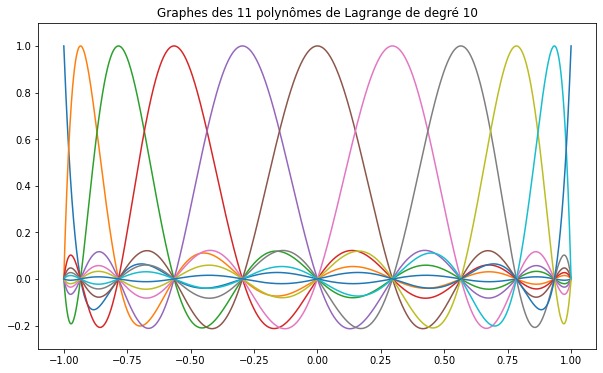

In [27]:
N = 10    # degré des polynômes
x = numpy.linspace(-1, 1, 1000)    # discrétisation du segment [-1, 1] en 1000 points
xi, _ = gll(N)    # construction des points de colocation

# Tracé de la figure
pyplot.figure(figsize=(10, 6))

for _i in range(-1,N):
    pyplot.plot(x, lagrange(N, _i, x, xi))

pyplot.ylim(-0.3, 1.1)
pyplot.title(f"Graphes des {N+1} polynômes de Lagrange de degré {N}")
pyplot.show()

### Interpolation d'une fonction lisse par les polynômes de Lagrange

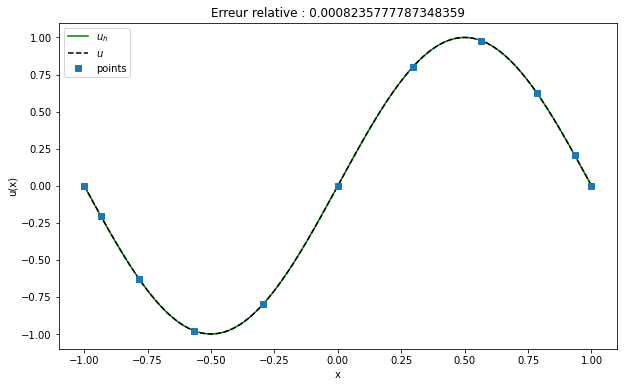

In [28]:
# Fonction à interpoler
u = lambda x : numpy.sin( numpy.pi * x)

# Discrétisation du segment [-1, 1] en nx points
nx = 1000
x  = numpy.linspace(-1, 1, nx)

# Evaluation de la fonction à interpoler sur la grille
u_ = u(x)

# Paramétrisation des polynômes : N est le degré des polynômes
N = 10
[xi, w] = gll(N)               # définition des points de collocation GLL
ui = numpy.interp(xi, x, u_)   # interpolation de u

# Initialisation des polynômes
Lp = numpy.zeros((N+1, len(x)))    # Lp[j, i] est le j-ième polynome evalue en x[i]

for i in range(0, len(x)):    # iération sur les points de la discrétisation
    for j in range(-1, N):    # itération sur l'indexe du polynome
        Lp[j+1, i] = lagrange(N, j, x[i], xi)

######################################################
# Calcul de l'interpolation
s = x * 0                       # initialisation
for j in range(0, N + 1):       # itération sur l'indice de la somme
    s = s + Lp[j, :] * ui[j]    # ajout du terme d'indice j
#
######################################################

erreur = numpy.sum((numpy.abs(u_ - s))) / numpy.sum(numpy.abs(u_)) * 100    # calcul de l'erreur

# Visualisation
pyplot.figure(figsize=(10, 6))
pyplot.plot(x, s, 'k-', color='green', label='$u_h$')
pyplot.plot(x, u_, 'k--', label='$u$')
pyplot.plot(xi, ui, 's', label='points')
pyplot.title(f"Erreur relative : {erreur}")
pyplot.xlabel('x')
pyplot.ylabel('u(x)')

pyplot.legend(loc="upper left")
pyplot.show()

### Schéma d'intégration

\begin{eqnarray*} 
    \int_{-1}^1 u(x) \ dx \approx \int _{-1}^1 P_N(x) dx = \sum_{i=1}^{N+1} w_i u(x_i)
\end{eqnarray*}

avec 

\begin{eqnarray*}
    P_N(x)= \sum_{i=1}^{N+1} u(x_i) \ l_i^{(N)}(x).
\end{eqnarray*}

Les points sont ceux de Gauss-Lobato-Legendre et les poids sont alors calculés ainsi

\begin{eqnarray*} 
    w_i= \int_{-1}^1 l_i^{(N)}(x) \ dx
\end{eqnarray*}

Valeur théorique: 0.6666666666666666
Valeur numérique: 0.6666680198366653


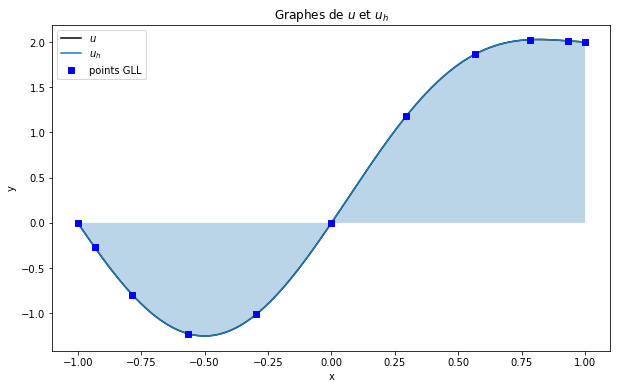

In [29]:
# Discrétisation du segment [-1, 1] en nx points
nx = 1000
x  = numpy.linspace(-1, 1, nx)

# Fonction à intégrer et valeur de l'intégrale définie
u  = lambda x : numpy.power(x, 2) + x + numpy.sin(numpy.pi * x)
u_ = u(x)
intU = 2./3

################################################
# INTEGRATION NUMERIQUE
# ----------------------------------------------

# Choix de l'ordre
N = 10

# Construction des points et poids
xi, w = gll(N)

# Evaluation de la fonction aux points GLL
ui = numpy.interp(xi, x, u_)

# Calcul du membre de droite
intUh = 0
for i in range(len(w)):
    intUh +=  w[i] * ui[i]
################################################

print(f'Valeur théorique: {intU}')
print(f'Valeur numérique: {intUh}')

################################################
# VISUALISATION
# ----------------------------------------------

# Interpolant de Lagrange
lp = numpy.zeros((N + 1, len(x)))
for i in range(0, len(x)):
    for j in range(-1, N):
        lp[j + 1, i] = lagrange(N, j, x[i], xi)
s = numpy.zeros_like(x)
for j in range(0, N + 1):   
    s = s + lp[j, :] * ui[j]

# Graphes
pyplot.figure(figsize=(10, 6))
pyplot.plot(x, u_, 'k-', label='$u$')

pyplot.plot(x, s, label='$u_h$')
pyplot.fill_between(x, s, numpy.zeros_like(x), alpha=0.3)

pyplot.plot(xi, ui, 'bs', label='points GLL')

pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('Graphes de $u$ et $u_h$')

pyplot.legend()
pyplot.show()
################################################

### Dérivation des polynômes de Lagrange

> https://github.com/heinerigel/coursera/blob/master/Notebooks4Coursera/W9/legendre.py

In [30]:
def legendre(N, x):
    """
    Returns the value of Legendre Polynomial P_N(x) at position x[-1, 1].
    """
    P = numpy.zeros(2 * N)

    if N == 0:
        P[0] = 1
    elif N == 1:
        P[1] = x
    else:
        P[0] = 1
        P[1] = x
    for i in range(2, N + 1):
        P[i] = (1.0 / float(i)) * ((2 * i - 1) * x * P[i - 1] - (i - 1) *
                                   P[i - 2])

    return(P[N])

> https://github.com/heinerigel/coursera/blob/master/Notebooks4Coursera/W9/lagrange1st.py

In [31]:
def lagrange1st(N):
    """
    # Calculation of 1st derivatives of Lagrange polynomials
    # at GLL collocation points
    # out = legendre1st(N)
    # out is a matrix with columns -> GLL nodes
    #                        rows -> order
    """
    # Modification du comportement de lagrange()
    def lagrange(N, i, x):
        """
        Function to calculate  Lagrange polynomial for order N and polynomial
        i[0, N] at location x.
        """
        [xi, weights] = gll(N)
        fac = 1
        for j in range(-1, N):
            if j != i:
                fac = fac * ((x - xi[j + 1]) / (xi[i + 1] - xi[j + 1]))
        return fac

    out = numpy.zeros([N+1, N+1])

    [xi, w] = gll(N)

    # initialize dij matrix (see Funaro 1993)
    d = numpy.zeros([N + 1, N + 1])

    for i in range(-1, N):
        for j in range(-1, N):
            if i != j:
                d[i + 1, j + 1] = legendre(N, xi[i + 1]) / \
                    legendre(N, xi[j + 1]) * 1.0 / (xi[i + 1] - xi[j + 1])
            if i == -1:
                if j == -1:
                    d[i + 1, j + 1] = -1.0 / 4.0 * N * (N + 1)
            if i == N-1:
                if j == N-1:
                    d[i + 1, j + 1] = 1.0 / 4.0 * N * (N + 1)

    # Calculate matrix with 1st derivatives of Lagrange polynomials
    for n in range(-1, N):
        for i in range(-1, N):
            sum = 0
            for j in range(-1, N):
                sum = sum + d[i + 1, j + 1] * lagrange(N, n, xi[j + 1])

            out[n + 1, i + 1] = sum
    return(out)

# Ondes élastiques 1.D homogènes : les éléments spectraux

> https://en.wikipedia.org/wiki/Spectral_element_method

### Description de l'algorithme

On souhaite résoudre l'équation

$$ \rho(x) \partial_t^2 u(t; x) - \partial_x \left[ \mu(x) \partial_x u(t; x) \right] = f(t; x) $$

à l'aide de la méthode des éléments spectraux. On choisit ici comme second membre une onde de type Ricker.

> https://en.wikipedia.org/wiki/Ricker_wavelet

1. **Ecriture de la formulation variationnelle**

2. **Application des conditions aux limites**

On choisit ici des conditions de Neumann sur le déplacement $u$, qui correspondent au cas *no-stress*.

3. **Approximation du champ $u$ par interpolation**

> $$ u(t; x) \approx \bar{u}(t;x) = \sum_{i=1}^{n} u_i(t) \varphi_i(t) $$

4. **Evaluer les formes à l'aide des fonctions de base**

5. **Ecriture de la forme faible sous forme de système linéaire**

> $$ \mathbf{M}^T\partial_t^2 \mathbf{u} + \mathbf{K}^T\mathbf{u} = \mathbf{f} $$

où $\mathbf{M}$ est la matrice de masse, et $\mathbf{K}$ la matrice de raideur.

6. **Extrapolation en temps**

> $$ \mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt) $$

Cette méthode est rigoureusement la même que pour le déploiement d'éléments finis classiques, la subtilité étant dans le choix d'une base adaptée pour une résolution efficiente du système linéaire.

---

#### Interpolation par polynômes de Lagrange

Au niveau des éléments, on effectue le changement de variable spatial $x \mapsto \xi \in [-1, 1]$ représentant l'élément d'espace. 

$$ \varphi_i \ \rightarrow \ \ell_i^{(N)} (\xi) \ := \ \prod_{j \neq i}^{N+1} \frac{\xi - \xi_j}{\xi_i-\xi_j}, \qquad   i,j = 1, 2, \dotsc , N + 1 $$

---

#### Choix du schéma d'intégration

On choisit la quadrature de Gauss-Lobatto-Legendre pour approcher l'intégrale $\int f(x) dx$.

$$ \int_{-1}^1 f(x) \ dx \approx \int _{-1}^1 P_N(x) dx = \sum_{i=1}^{N+1}
 w_i f(x_i) $$

#### Setup

In [32]:
nt    = 600           # nombre de points de temps
xmax  = 10000.        # longueur du domaine : 10 km [m]
vs    = 2500.         # vitesse de l'onde sismique [m/s]
rho   = 2000          # densité du matériau [kg/m^3]
mu    = rho * vs**2   # module de cisaillement
N     = 2             # degré des polynomes de Lagrange
ne    = 125           # nombre d'éléments
Tdom  = .1            # période dominante de l'onde de Ricker
iplot = 5             # intervalle entre deux affichages

# Matrices élémentaires du problème
Me = numpy.zeros(N+1, dtype=numpy.float32)          # matrice de masse
Ke = numpy.zeros((N+1,N+1), dtype=numpy.float32)    # matrice de raideur

# Initialisation des points et poids G.L.L
[xi, w] = gll(N)

# Discrétisation spatiale
le = xmax/ne        # longueur d'un élément spatial

k = 0
xg = numpy.zeros((N*ne)+1)    # vecteur des coordonnées physiques des points de GLL pour tous les éléments
xg[k] = 0                     # origine en 0
for i in range(1,ne+1):       # itération sur le nombre d'éléments
    for j in range(0,N):      # itération sur le nombre de points GLL par élément
        k = k+1
        xg[k] = (i-1)*le + .5*(xi[j+1]+1)*le    # absisse du j-ième point d'intégration de l'élément i

# Discrétisation temporelle : CFL et pas de temps
dxmin = numpy.min(numpy.diff(xg))    # pas d'espace minimal de la discrétisation  
eps = 0.2                            # Courant-Friedrichs-Lewy value
dt = eps*dxmin/vs                    # pas de temps global

# Changement de variable x --> \xi et son jacobien
J = le/2
Ji = 1/J

# Dérivées premières des polynômes de Lagrange
l1d = lagrange1st(N)

#### Assemblage de la matrice de masse $\mathbf{M}$

$$ M_{ji}^e \ = \ w_j  \ \rho (\xi)  \ \frac{\mathrm{d}x}{\mathrm{d}\xi} \delta_{ij} \vert_ {\xi = \xi_j} $$

In [33]:
# Matrice de masse élémentaire
for i in range(0, N+1):
    Me[i] = rho * w[i] * J    # stockée comme un vecteur : diagonale de la matrice

# Assemblage de la matrice de masse globale
k = -1                   # initialisation de l'indice de parcours
ng = (ne-1)*N + N + 1    # nombre d'éléments non-nuls
M = numpy.zeros(2*ng)    # matrice "plate" représentant la matrice M

for i in range(1, ne+1):    # itération sur le nombre d'éléments
    for j in range(0, N+1):    # itération sur les points par élément
        k = k + 1
        if i>1 :
            if j==0 :
                k = k - 1
        M[k] = M[k] + Me[j]    # calcul

# Calcul de l'inverse de la matrice de masse M
Minv = numpy.identity(ng)

for i in range(0, ng):
    Minv[i,i] = 1./M[i]

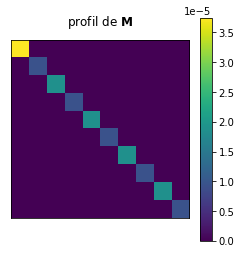

In [34]:
pyplot.matshow(Minv[:10,:10])
pyplot.colorbar()
pyplot.title("profil de $\mathbf{M}$")
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

#### Assemblage de la matrice de raideur $\mathbf{K}$

$$ K_{ji}^e \ = \ \sum_{k = 1}^{N+1} w_k \mu (\xi) \partial_\xi \ell_j (\xi) \partial_\xi \ell_i (\xi) \left(\frac{\mathrm{d}\xi}{\mathrm{d}x} \right)^2 \frac{\mathrm{d}x}{\mathrm{d}\xi} \vert_{\xi = \xi_k} $$

In [35]:
# Matrice de raideur élémentaire
for i in range(0, N+1):
    for j in range(0, N+1):
        for k in range(0, N+1):
            Ke[i,j] += mu * w[k] * Ji * l1d[i,k] * l1d[j,k]

# Matrice de raideur globale
K = numpy.zeros([ng, ng])
## assemblage intérieur
for k in range(1,ne+1):    # itération sur les éléments
    i0 = (k-1)*N + 1
    j0 = i0
    for i in range(-1,N):    # itération sur les 
        for j in range(-1,N):    # itération sur les 
            K[i0+i,j0+j] = Ke[i+1,j+1]

for k in range(2,ne+1):    # assemblage aux bords
    i0 = (k - 1)*N
    j0 = i0
    K[i0,j0] = Ke[0,0] + Ke[N,N]

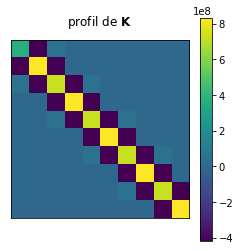

In [36]:
pyplot.matshow(K[:10,:10])
pyplot.colorbar()
pyplot.title("profil de $\mathbf{K}$")
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

#### Extrapolation en temps

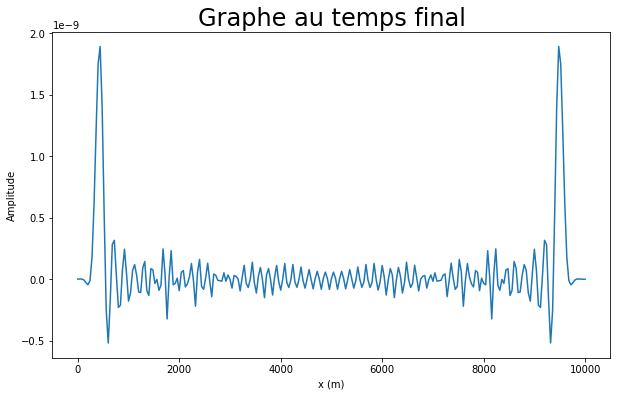

In [37]:
# Initialisation du second membre
src  = ricker(dt, Tdom)
isrc = int(numpy.floor(ng/2))

# Initialisation des vecteurs de la simulation
u = numpy.zeros(ng)    # vecteur solution
uold = u            # solution au temps it
unew = u            # solution au temps it+1
f = u               # vecteur second membre

################################################
# EXTRAPOLATION EN TEMPS
# ----------------------------------------------
for it in range(nt): 
    # Déclaration de l'onde source
    f = numpy.zeros(ng)
    if it < len(src):
        f[isrc-1] = src[it-1] 
               
    # Calcul de la nouvelle solution
    unew = dt**2 * Minv @ (f - K @ u) + 2 * u - uold
    uold, u = u, unew
################################################

# Visualisation
pyplot.figure(figsize=(10,6))
pyplot.plot(xg, u, label="$u(x)$")
pyplot.title('Graphe au temps final', size=24)
pyplot.xlabel('x (m)')
pyplot.ylabel('Amplitude')
pyplot.show()